# TimeEval parameter optimization result analysis of extra experiments (2)

Extra experiments and their reason:

- Random Black Forest (RR): was missing in extra1 run, because of a configuration error
- ARIMA: Inspect (originally fixed) parameter "distance_metric"

In [1]:
# imports
import json
import warnings
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

from pathlib import Path
from timeeval import Datasets

## Configuration

Define data and results folder:

In [2]:
# constants and configuration
data_path = Path("/home/projects/akita/data") / "test-cases"
result_root_path = Path("/home/projects/akita/results")
experiment_result_folder = "2021-10-17_optim-extra2"

# build paths
result_paths = [d for d in result_root_path.iterdir() if d.is_dir()]
print("Available result directories:")
display(result_paths)

result_path = result_root_path / experiment_result_folder
print("\nSelecting:")
print(f"Data path: {data_path.resolve()}")
print(f"Result path: {result_path.resolve()}")

Available result directories:


[PosixPath('/home/projects/akita/results/2021-10-11_optim-part4'),
 PosixPath('/home/projects/akita/results/2021-09-27_shared-optim'),
 PosixPath('/home/projects/akita/results/2021-10-06_optim-part1'),
 PosixPath('/home/projects/akita/results/2021-09-27_default-params-1&2&3&4-merged'),
 PosixPath('/home/projects/akita/results/2021-10-14_optim-extra'),
 PosixPath('/home/projects/akita/results/.ipynb_checkpoints'),
 PosixPath('/home/projects/akita/results/2021-10-08_optim-part3'),
 PosixPath('/home/projects/akita/results/2021-10-07_optim-part2'),
 PosixPath('/home/projects/akita/results/2021-10-17_optim-extra2'),
 PosixPath('/home/projects/akita/results/2021-10-12_optim-part5'),
 PosixPath('/home/projects/akita/results/2021-10-12_optim-part6')]


Selecting:
Data path: /home/projects/akita/data/test-cases
Result path: /home/projects/akita/results/2021-10-17_optim-extra2


Load results and dataset metadata:

In [3]:
# load results
print(f"Reading results from {result_path.resolve()}")
df = pd.read_csv(result_path / "results.csv")

# add dataset_name column
df["dataset_name"] = df["dataset"].str.split(".").str[0]

# load dataset metadata
dmgr = Datasets(data_path)

Reading results from /home/projects/akita/results/2021-10-17_optim-extra2


Extract target optimized parameter names that were iterated in this run (per algorithm):

In [4]:
algo_param_mapping = {}
algorithms = df["algorithm"].unique()
param_ignore_list = ["max_anomaly_window_size", "anomaly_window_size", "neighbourhood_size", "window_size", "n_init_train", "embed_dim_range"]

for algo in algorithms:
    param_sets = df.loc[df["algorithm"] == algo, "hyper_params"].unique()
    param_sets = [json.loads(ps) for ps in param_sets]
    param_names = np.unique([name for ps in param_sets for name in ps if name not in param_ignore_list])
    search_space = set()
    for param_name in param_names:
        values = []
        for ps in param_sets:
            try:
                values.append(ps[param_name])
            except:
                pass
        values = np.unique(values)
        if values.shape[0] > 1:
            search_space.add(param_name)
    algo_param_mapping[algo] = list(search_space)

for algo in algo_param_mapping:
    print(algo, algo_param_mapping[algo])

ARIMA ['distance_metric']
Random Black Forest (RR) ['n_estimators', 'bootstrap', 'n_trees']


Extract optimized parameters and their values (columns: optim_param_name and optim_param_value) for each experiment:

In [5]:
def extract_hyper_params(algo):
    param_names = algo_param_mapping[algo]
    def extract(value):
        params = json.loads(value)
        result = ""
        for name in param_names:
            try:
                value = params[name]
                result += f"{name}={value},"
            except KeyError:
                pass
        
        if result == "":
            return pd.Series([np.nan, np.nan], index=["optim_param_name", "optim_param_value"])
        elif len(param_names) == 1:
            return pd.Series(result.rsplit(",", 1)[0].split("="), index=["optim_param_name", "optim_param_value"])
        else:
            return pd.Series(["", "".join(result.rsplit(",", 1))], index=["optim_param_name", "optim_param_value"])
    return extract

df[["optim_param_name", "optim_param_value"]] = ""
for algo in algo_param_mapping:
    df_algo = df.loc[df["algorithm"] == algo]
    df.loc[df_algo.index, ["optim_param_name", "optim_param_value"]] = df_algo["hyper_params"].apply(extract_hyper_params(algo))

Define utility functions

In [6]:
def load_scores_df(algorithm_name, dataset_id, optim_params, repetition=1):
    params_id = df.loc[(df["algorithm"] == algorithm_name) & (df["collection"] == dataset_id[0]) & (df["dataset"] == dataset_id[1]) & (df["optim_param_name"] == optim_params[0]) & (df["optim_param_value"] == optim_params[1]), "hyper_params_id"].item()
    path = (
        result_path /
        algorithm_name /
        params_id /
        dataset_id[0] /
        dataset_id[1] /
        str(repetition) /
        "anomaly_scores.ts"
    )
    return pd.read_csv(path, header=None)

Define plotting functions:

In [7]:
default_use_plotly = True
try:
    import plotly.offline
except ImportError:
    default_use_plotly = False

def plot_scores(algorithm_name, dataset_name, use_plotly: bool = default_use_plotly, **kwargs):
    if isinstance(algorithm_name, tuple):
        algorithms = [algorithm_name]
    elif not isinstance(algorithm_name, list):
        raise ValueError("Please supply a tuple (algorithm_name, optim_param_name, optim_param_value) or a list thereof as first argument!")
    else:
        algorithms = algorithm_name
    # construct dataset ID
    dataset_id = ("GutenTAG", f"{dataset_name}.unsupervised")

    # load dataset details
    df_dataset = dmgr.get_dataset_df(dataset_id)

    # check if dataset is multivariate
    dataset_dim = df.loc[df["dataset_name"] == dataset_name, "dataset_input_dimensionality"].unique().item()
    dataset_dim = dataset_dim.lower()
    
    auroc = {}
    df_scores = pd.DataFrame(index=df_dataset.index)
    skip_algos = []
    algos = []
    for algo, optim_param_name, optim_param_value in algorithms:
        optim_params = f"{optim_param_name}={optim_param_value}"
        algos.append((algo, optim_params))
        # get algorithm metric results
        try:
            auroc[(algo, optim_params)] = df.loc[
                (df["algorithm"] == algo) & (df["dataset_name"] == dataset_name) & (df["optim_param_name"] == optim_param_name) & (df["optim_param_value"] == optim_param_value),
                "ROC_AUC"
            ].item()
        except ValueError:
            warnings.warn(f"No ROC_AUC score found! Probably {algo} with params {optim_params} was not executed on {dataset_name}.")
            auroc[(algo, optim_params)] = -1
            skip_algos.append((algo, optim_params))
            continue

        # load scores
        training_type = df.loc[df["algorithm"] == algo, "algo_training_type"].values[0].lower().replace("_", "-")
        try:
            df_scores[(algo, optim_params)] = load_scores_df(algo, ("GutenTAG", f"{dataset_name}.{training_type}"), (optim_param_name, optim_param_value)).iloc[:, 0]
        except (ValueError, FileNotFoundError):
            warnings.warn(f"No anomaly scores found! Probably {algo} was not executed on {dataset_name} with params {optim_params}.")
            df_scores[(algo, optim_params)] = np.nan
            skip_algos.append((algo, optim_params))
    algorithms = [a for a in algos if a not in skip_algos]

    if use_plotly:
        return plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs)
    else:
        return plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs)

def plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs):
    import plotly.offline as py
    import plotly.graph_objects as go
    import plotly.figure_factory as ff
    import plotly.express as px
    from plotly.subplots import make_subplots

    # Create plot
    fig = make_subplots(2, 1)
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, i], name=f"channel-{i}"), 1, 1)
    else:
        fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, 1], name="timeseries"), 1, 1)
    fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset["is_anomaly"], name="label"), 2, 1)
    
    for item in algorithms:
        algo, optim_params = item
        fig.add_trace(go.Scatter(x=df_scores.index, y=df_scores[item], name=f"{algo}={auroc[item]:.4f} ({optim_params})"), 2, 1)
    fig.update_xaxes(matches="x")
    fig.update_layout(
        title=f"Results of {','.join(np.unique([a for a, _ in algorithms]))} on {dataset_name}",
        height=400
    )
    return py.iplot(fig)

def plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs):
    import matplotlib.pyplot as plt

    # Create plot
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            axs[0].plot(df_dataset.index, df_dataset.iloc[:, i], label=f"channel-{i}")
    else:
        axs[0].plot(df_dataset.index, df_dataset.iloc[:, 1], label=f"timeseries")
    axs[1].plot(df_dataset.index, df_dataset["is_anomaly"], label="label")
    
    for item in algorithms:
        algo, optim_params = item
        axs[1].plot(df_scores.index, df_scores[item], label=f"{algo}={auroc[item]:.4f} ({optim_params})")
    axs[0].legend()
    axs[1].legend()
    fig.suptitle(f"Results of {','.join(np.unique([a for a, _ in algorithms]))} on {dataset_name}")
    fig.tight_layout()
    return fig

## Parameter assessment

In [8]:
sort_by = ("ROC_AUC", "mean")
metric_agg_type = ["min", "mean", "median"]
time_agg_type = "mean"
aggs = {
    "PR_AUC": metric_agg_type,
    "ROC_AUC": metric_agg_type,
    "train_main_time": time_agg_type,
    "execute_main_time": time_agg_type,
    "repetition": "count"
}

df_tmp = df.reset_index()
df_tmp = df_tmp.groupby(by=["algorithm", "optim_param_name", "optim_param_value"]).agg(aggs)
df_tmp = df_tmp.reset_index()
df_tmp = df_tmp.sort_values(by=["algorithm", "optim_param_name", sort_by], ascending=False)
df_tmp = df_tmp.set_index(["algorithm", "optim_param_name", "optim_param_value"])

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_tmp)

PR_AUC  \
                                                                                             min   
algorithm                optim_param_name optim_param_value                                        
Random Black Forest (RR)                  n_estimators=200,bootstrap=False,n_trees=10   0.567433   
                                          n_estimators=100,bootstrap=True,n_trees=10    0.453341   
                                          n_estimators=200,bootstrap=True,n_trees=10    0.457374   
                                          n_estimators=10,bootstrap=True,n_trees=100    0.434542   
                                          n_estimators=10,bootstrap=True,n_trees=200    0.434308   
                                          n_estimators=100,bootstrap=False,n_trees=10   0.450179   
                                          n_estimators=10,bootstrap=True,n_trees=10     0.435874   
                                          n_estimators=10,bootstrap=False,n_trees=10    0.395472   
                                          n_estimators=10,bootstrap=False,n_trees=100   0.396960   
                                          n_estimators=10,bootstrap=False,n_trees=200   0.431431   
                                          n_estimators=100,bootstrap=False,n_trees=100       NaN   
                                          n_estimators=100,bootstrap=False,n_trees=200       NaN   
                                          n_estimators=100,bootstrap=True,n_trees=100        NaN   
                                          n_estimators=100,bootstrap=True,n_trees=200        NaN   
                                          n_estimators=200,bootstrap=False,n_trees=100       NaN   
                                          n_estimators=200,bootstrap=False,n_trees=200       NaN   
                                          n_estimators=200,bootstrap=True,n_trees=100        NaN   
                                          n_estimators=200,bootstrap=True,n_trees=200        NaN   
ARIMA                    distance_metric  twed                                          0.028961   
                                          euclidean                                     0.057625   
                                          garch                                         0.025700   
                                          fourier                                       0.057153   
                                          mahalanobis                                   0.013498   
                                          dtw                                           0.001008   
                                          ssa                                           0.000710   
                                          edrs                                          0.005000   

                                                                                                  \
                                                                                            mean   
algorithm                optim_param_name optim_param_value                                        
Random Black Forest (RR)                  n_estimators=200,bootstrap=False,n_trees=10   0.722157   
                                          n_estimators=100,bootstrap=True,n_trees=10    0.656924   
                                          n_estimators=200,bootstrap=True,n_trees=10    0.658582   
                                          n_estimators=10,bootstrap=True,n_trees=100    0.649658   
                                          n_estimators=10,bootstrap=True,n_trees=200    0.649504   
                                          n_estimators=100,bootstrap=False,n_trees=10   0.656649   
                                          n_estimators=10,bootstrap=True,n_trees=10     0.650336   
                                          n_estimators=10,bootstrap=False,n_trees=10    0.642390   
                                          n_estimators=10,bootstrap=False,n_trees=100   0

#### Selected parameters

- Random Black Forest (RR): 
  ```json
  "Random Black Forest (RR)": {
      "bootstrap": false,
      "n_trees": 10,
      "n_estimators": 200
  }
  ```
- ARIMA:
  ```json
  "ARIMA": {
      "distance_metric": "twed"
  }
  ```

<ipython-input-7-964f728b5097>:38: UserWarning: No ROC_AUC score found! Probably Random Black Forest (RR) with params =bootstrap=False,n_trees=10,n_estimators=200 was not executed on ecg-type-variance.
  warnings.warn(f"No ROC_AUC score found! Probably {algo} with params {optim_params} was not executed on {dataset_name}.")
<ipython-input-7-964f728b5097>:38: UserWarning: No ROC_AUC score found! Probably Random Black Forest (RR) with params =bootstrap=True,n_trees=10,n_estimators=200 was not executed on ecg-type-variance.
  warnings.warn(f"No ROC_AUC score found! Probably {algo} with params {optim_params} was not executed on {dataset_name}.")
<ipython-input-7-964f728b5097>:38: UserWarning: No ROC_AUC score found! Probably Random Black Forest (RR) with params =bootstrap=False,n_trees=10,n_estimators=100 was not executed on ecg-type-variance.
  warnings.warn(f"No ROC_AUC score found! Probably {algo} with params {optim_params} was not executed on {dataset_name}.")


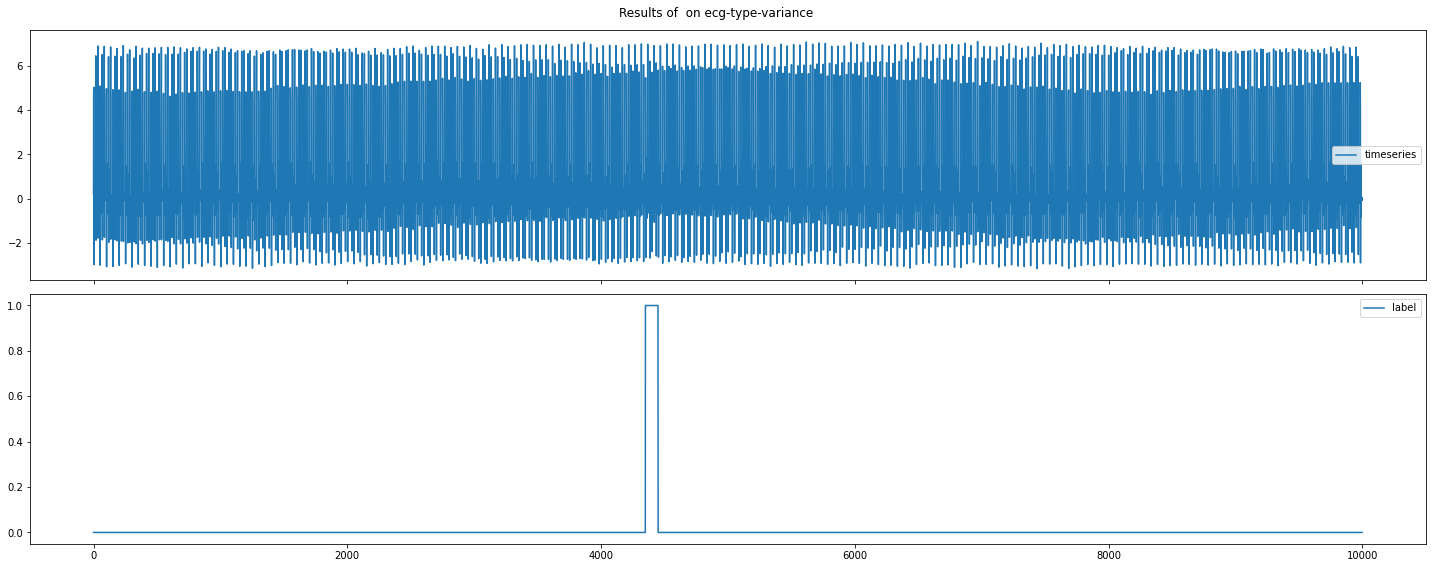

In [9]:
plot_scores([
    ("Random Black Forest (RR)", "", "bootstrap=False,n_trees=10,n_estimators=200"),
    ("Random Black Forest (RR)", "", "bootstrap=True,n_trees=10,n_estimators=200"),
    ("Random Black Forest (RR)", "", "bootstrap=False,n_trees=10,n_estimators=100")
], "ecg-type-variance", use_plotly=False)
plt.show()

Failed runs

In [10]:
df[df["status"] != "Status.OK"].groupby(by=["algorithm", "optim_param_name", "optim_param_value", "status"])[["repetition"]].count()

repetition
algorithm                optim_param_name optim_param_value                            status                  
Random Black Forest (RR)                  n_estimators=10,bootstrap=False,n_trees=200  Status.ERROR           7
                                          n_estimators=100,bootstrap=False,n_trees=100 Status.ERROR          10
                                          n_estimators=100,bootstrap=False,n_trees=200 Status.ERROR          10
                                          n_estimators=100,bootstrap=True,n_trees=100  Status.ERROR          10
                                          n_estimators=100,bootstrap=True,n_trees=200  Status.ERROR          10
                                          n_estimators=200,bootstrap=False,n_trees=10  Status.ERROR           3
                                          n_estimators=200,bootstrap=False,n_trees=100 Status.ERROR          10
                                          n_estimators=200,bootstrap=False,n_trees=200 Status.ERROR          10
                                          n_estimators=200,bootstrap=True,n_trees=100  Status.ERROR          10
                                          n_estimators=200,bootstrap=True,n_trees=200  Status.ERROR          10

In [11]:
algo = "Random Black Forest (RR)"
executions = [f for f in (result_path / algo).glob("**/execution.log") if not (f.parent / "anomaly_scores.ts").is_file()]
c = 0
for x in executions:
    with x.open() as fh:
        log = "".join(fh.readlines())
    if "status code '137'" in log:
        c += 1
    else:
        print(x.parent.parent.name)
        print("---------------------------------------------------------------------------------")
        print(log)
print(c)

90
